# internal wave packet evolution


Spatial decomposition of the vertical velocity field:

$
\begin{align}
w(x, y, t) &= \iint \hat w (k, m) e^{i(kx+mz-\omega t)} dk dm, \\
\omega^2 &= \frac{N^2 k^2 + f^2 m^2}{k^2+m^2}, 
\end{align}
$

At initial time:

$
\begin{align}
w(x, y, 0) &= \iint \hat w (k, m) e^{i(kx+mz)} dk dm, \\
\hat w (k, m) &=  \frac{1}{(2\pi)^2} \iint w (x, z) e^{-i(kx+mz)} dx dz,
\end{align}
$



In [1]:
import numpy as np
import xarray as xr

from numpy.fft import fftfreq, fftshift, ifftshift, fftn, ifftn
from scipy.interpolate import griddata

import matplotlib.pyplot as plt

import dashydro.theory as th

In [2]:
@xr.register_dataset_accessor("iw")
class InternalWave:
    """ Internal wave property container
    Minimum parameters are: omega, N, f
    
    """
    def __init__(self, xarray_obj):
        self._obj = xarray_obj
        # miscellaneous parameters
        self._verbosity = 0
        # core parameters
        #assert "kx" not in self._obj or "kz" not in self._obj, "kx and ky cannot be set simultaneously"
        if "omega" in self._obj:
            self._omega = self._obj["omega"]
        else:
            self._omega = None
        if "kx" in self._obj:
            self._kx = self._obj["kx"]
        else:
            self._kx = None
        self._ky = None
        if "kz" in self._obj:
            self._kz = self._obj["kz"]
        else:
            self._kz = None
        # dependent parameters
        self._kh = None
        self._kappa = None
        #
        self._cotan_theta = None
        self._theta = None
        self._phi = None
        #
        self._cg = None
        self._cg_x = None
        self._cg_y = None
        self._cg_z = None
        #
        self._gamma = None # steepness        
    
    def set_verbosity(self, verbosity):
        """ set verbosity levels, default is 0 (no outputs)"""
        self._verbosity = verbosity

    @property
    def omega(self):
        """Returns the wavenumber frequency
        """
        if self._omega is None:
            if "omega" in self._obj:
                self._omega = self._obj["omega"]
            elif self._kx is not None and self._kz is not None:
                if self._verbosity>0:
                    print("computing omega from kh and kz")
                f, N = self._obj.f, self._obj.N
                self._omega = np.sqrt( N**2 * self.kh**2 + f**2 * self._kz**2  )/self.kappa
                self._omega = self._omega.fillna(0.)
        return self._omega
        
    @property
    def kx(self):
        """Returns the x wavenumber
        """
        if self._kx is None:
            if "kx" in self._obj:
                self._kx = self._obj["kx"]
            elif self._kz is not None:
                if self._verbosity>0:
                    print("computing kx from kz and omega (via theta, assuming cotan(theta)>0 and ky=0)")
                self._kx = self.kz * self.cotan_theta
        return self._kx
    
    def set_kx(self, kx):
        """ Overwrite kx, ! does not update ky nor kz, 
        i.e. may break the dispersion relation
        """
        self._kx = kx

    @property
    def ky(self):
        """Returns the y wavenumber
        """
        if self._ky is None:
            if "ky" in self._obj:
                self._ky = self._obj["ky"]
            else:
                if self._verbosity>0:
                    print("Warning assumes ky=0 from now on")
                self._ky = 0.
        return self._ky

    @property
    def kz(self):
        """Returns the z wavenumber
        """
        if self._kz is None:
            if "kz" in self._obj:
                self._kz = self._obj["kz"]
            elif "kx" in self._obj:
                if self._verbosity>0:
                    print("computing kz from kx and omega (via theta)")
                self._kz = self.kh / self.cotan_theta
        #else:
        #    print("warning: kz was not updated due to existing cached value")
        #if self._kz is not None:
        #    self._kz = self._kz.rename("kz")
        return self._kz
    
    # https://docs.python.org/3.9/library/functions.html#property
    #@kz.setter
    #def kz(self, value):
    #    self._kz = value
    #    # reset kx, ky
    #    self._kx, self._ky = None, None
    
    @property
    def kh(self):
        """Returns the horizontal wavenumber magnitude, allways positive
        """
        if self._kh is None:
            if self.kx is not None:
                if self._verbosity>0:
                    print("computing kh from kx and ky")
                self._kh = np.sqrt(self.kx**2+self.ky**2)
            elif self.kz is not None:
                if self._verbosity>0:
                    print("computing kh from kz and omega (via cotan theta)")
                #cotan2_theta = get_cotan2_theta(omega, N, f)
                self._kh = np.abs(self.kz * self.cotan_theta)
            else:
                print("Not enough information to compute kh, returns None for now \n" \
                      +"Please set kx, ky, kz, or omega")
        if self._kh is not None:
            self._kh = self._kh.rename("kh")
        return self._kh

    @property
    def kappa(self):
        """Returns the 3D wavenumber magnitude
        """
        if self._kappa is None:
            if self.kx is not None and self.kz is not None:
                if self._verbosity>0:
                    print("computing kappa from kx and kz")
                #if self._ky is None:
                #    print("Warning: assumes ky=0")
                #    self._ky = 0
                #else:
                #    _ky = self._ky
                self._kappa = np.sqrt(self.kx**2+self.ky**2+self.kz**2).rename("kappa")
            else:
                print("Not enough information to compute kappa, returns None for now \n" \
                      +"Please set kx, ky, kz")
        return self._kappa
    
    @property
    def cotan_theta(self):
        """Return the cotangent of the angle of the wavenumber with the horizontal:
        
        cotan(theta) = kh/kz = ± np.sqrt( (omega**2-f**2) / (N**2-omega**2) )
        
        """
        if self._cotan_theta is None:
            if self._kx is not None and self._kz is not None:
                if self._verbosity>0:
                    print("computing cotan theta from kx and kz")
                # only route to have a non-positive sign
                self._cotan_theta = self.kh / self.kz
            else:
                if self._verbosity>0:
                    print("computing cotan theta from omega, N, and f. cotan(theta) assumed positive !")
                omega, N, f = self._obj.omega, self._obj.N, self._obj.f
                self._cotan_theta = np.sqrt((omega**2-f**2)/(N**2-omega**2))
        self._cotan_theta = self._cotan_theta.rename("cotan_theta")
        return self._cotan_theta
        
    @property
    def theta(self):
        """Return the angle with the horizontal
        Negative values are obtained by setting kx and kz first
        """
        if self._theta is None:
            if self._verbosity>0:
                print("computing theta from cotan theta")
            self._theta = (np.arctan(1/self.cotan_theta)
                           .rename("theta")
                           .fillna(0.)
                          )
        return self._theta

    @property
    def phi(self):
        """Return the azimuth phi of the horizontal wavenumber"""
        if self._phi is None:
            #if self._ky is None:
            #    print("Warning: assumes ky=0")
            #    self._ky = 0.
            #else:
            #    _ky = self._ky
            if self.kx is not None:
                if self._verbosity>0:
                    print("computing phi from kx and ky")
                self._phi = np.arctan2(self.ky, self.kx).rename("phi")
            else:
                print("Not enough information to compute phi, returns None for now \n" \
                      +"Set at least kx")
        return self._phi
    
    
    @property
    def cg(self):
        """Return the group speed magnitude"""
        if self._cg is None:
            omega, f, N = self.omega, self._obj.f, self._obj.N
            self._cg = ((N**2-f**2)
                  * np.cos(self.theta)*np.sin(self.theta)
                  /self.kappa/omega
                 )
        return self._cg
    
    @property
    def cg_x(self):
        """Return the group speed in the x direction"""
        if self._cg_x is None:
            self._cg_x = (self.cg*np.sin(self.theta)*np.cos(self.phi)
                         ).rename("cg_x")        
        return self._cg_x

    @property
    def cg_y(self):
        """Return the group speed in the y direction"""
        if self._cg_y is None:
            self._cg_y = (self.cg*np.sin(self.theta)*np.sin(self.phi)
                         ).rename("cg_y")        
        return self._cg_y

    @property
    def cg_z(self):
        """Return the group speed in the z direction"""
        if self._cg_z is None:
            self._cg_z = (-self.cg*np.cos(self.theta)
                         ).rename("cg_z")        
        return self._cg_z
    
    @property
    def gamma(self):
        """Return the steepness of energy propagation"""
        if self._gamma is None:
            self._gamma = -self.cotan_theta.rename("gamma")   
        return self._gamma
    
    def reflected_wave(self, slope_x, slope_y, 
                       z_0=0,
                       tapper=None,
                       interp_na_dim=None,
                      ):
        """Computes the wave reflected agains a bathymetric slope
        Matches Gerkema's conventions (section 6.4)
        
        w_i = e^[i (x kx + y ky + z kz - omega t) ]
        w_r = Q e^[i (x kx_r + y ky_r + z kz_r - omega t) ]
        
        The seafloor is assumed to be given by: 
            z = z_0 + gamma x u + delta x v
        
        Parameters
        ----------
        slope_x: float, xr.DataArray
            bathymetric slope in x direction = - d water_depth/dx
            This is gamma in Gerkema's text book
        slope_y: float, xr.DataArray
            bathymetric slope in y direction = - d water_depth/dy
            This is delta in Gerkema's text book
        z_0: float
            reference level, i.e. seafloor coordinate at x=0 and y=0
        interp_na_dim: str
            dimension along which to interpolate NaN, leaves NaNs otherwise
            
        Returns
        -------
        kx_r
        ky_r
        kz_r
        Q
        
        """
        omega, f, N = self.omega, self._obj.f, self._obj.N
        C = f**2 - omega**2
        D = N**2 - omega**2
        #
        kx, ky, kz = self.kx, self.ky, self.kz
        #
        q = D*( (kx + slope_x * kz)**2 + (ky + slope_y * kz)**2 ) /kz**2 
        _scale = 1./(C + D*(slope_x**2+slope_y**2))
        # tapper 
        if tapper is not None:
            _tapper = tapper/N**2
            _scale = np.tanh(_scale/_tapper)*_tapper
        q = q*_scale
        # interpolate NaNs if need be
        if interp_na_dim is not None:
            q = interp_na(q, interp_na_dim)
        kx_r = kx + slope_x * (1-q) * kz
        ky_r = ky + slope_y * (1-q) * kz
        kz_r = q*kz
        Q = -q * ( omega*(C*kz-D*(slope_x*kx+slope_y*ky)) + 1j*D*f*(slope_y*kx-slope_x*ky) ) \
            /( omega*(C*kz_r-D*(slope_x*kx_r+slope_y*ky_r)) + 1j*D*f*(slope_y*kx_r-slope_x*ky_r) )
        #if interp_na_dim is not None:
        #    Q = interp_na(Q, interp_na_dim)
        # correct for vertical offset of the seafloor
        Q = Q*np.exp(1j*(kz_r - kz)*z_0)
        return kx_r, ky_r, kz_r, Q, q
    
    def camplitude(self,
                  x,y,z, 
                  variable="w", 
                  kx=None, ky=None, kz=None, 
                  amplitude=1.,
                 ):
        """ Evaluate the complex amplitude of the internal wave

        e^[i (x kx + y ky + z kz - omega t) ]

        Parameters
        ----------
        x,y,z: float, xr.DataArray
            Coordinates where the amplitude has to be evaluated
        variable: str, optional
            Variable corresponding to the desired amplitude, e.g. "w", "b", ...
        kx, ky, kz: float, xr.DataArray, optional
            Manually set wavenumbers (useful for reflected configurations)
        amplitude: float, xr.DataArray, optional
            Manually set amplitude (useful for reflected configurations)
        """
        if kx is None:
            kx = self._kx
        if ky is None:
            ky = self.ky
        if kz is None:
            kz = self.kz
        kh = np.sqrt(kx**2+ky**2)
        omega, f, N = self._obj.omega, self._obj.f, self._obj.N
        #
        w = np.exp(1j*(kx*x+ky*y+kz*z))
        if variable=="w":
            out = w
        elif variable=="b":
            out = w * N**2 /(1j*omega)
        elif variable=="p":
            out = -w * (N**2-omega**2) /(omega*kz)
        elif variable=="u":
            out = -w * (kx + 1j*ky*f/omega)*kz/kh**2
        elif variable=="v":
            out = -w * (ky - 1j*kx*f/omega)*kz/kh**2

        return out.rename(variable)
    
    def plot(self):
        """Plot data on a map."""
        return "plotting!"
    
    
def interp_na(da, dims):
    """ interpolate NaNs along potentially multiple dimensions"""
    if isinstance(dims, str):
        da = da.interpolate_na(dim=interp_na_dim)
    elif isinstance(dims, list):
        for dim in dims:
            da = da.interpolate_na(dim=dim)
    return da
    

### environmental parameters

In [3]:
lat = 43
#f = 2 *2*np.pi/86164.1 * np.sin(lat*np.pi/180) # rad/s
f = 0. # debug
N = 1e-3 # rad/s

In [4]:
#Lx, Lz = 50e3, 1e3
#Lx, Lz = 100e3, 10e3
#dx, dz = 200, 5

# debug
Lx, Lz = 10e3, 1e3
dx, dz = 20, 5

ds = xr.Dataset(dict(x=np.arange(-Lx/2,Lx/2,dx),
                     z=np.arange(-Lz/2,Lz/2,dz),
                    ))

#ds = ds.assign_coords(h=-gamma*ds.x)
#xi_p =  mu*ds.x - ds.z
#xi_m = -mu*ds.x - ds.z
#ds["F"] = F(xi_p).where(ds.z+0.*ds.x>-ds.h)
#ds["G"] = G(xi_m).where(ds.z+0.*ds.x>-ds.h)

ds["kx"] = ("kx", fftshift(fftfreq(ds.x.size, d=dx))) # cycles per meters
ds["kz"] = ("kz", fftshift(fftfreq(ds.z.size, d=dz))) # cycles per meters

#ds["kappa"] = np.sqrt( ds.kx**2 + ds.kz**2 ) # cycles per meters

#ds["omega"] = np.sqrt( (N**2 * ds.kx**2 + f**2 * ds.kz**2) )/ds.kappa
#ds["omega"] = ds.omega.fillna(0.)

# required to use accessor
ds.attrs.update(**dict(f=f, N=N))

#
ds["omega"] = ds.iw.omega

In [5]:
#ds.iw.set_verbosity(2)
#ds.iw.theta

### initial shape

In [6]:
kz_0 = 2*np.pi/50. # vertical wavenumber
delta_cross = 100. # meters
#delta_along = 5e3 # meters
delta_along = 5e2 # meters debug
#omega_0 = f*1.01
omega_0 = N/10 # debug
mu =  th.get_mu(omega_0, f, N)

# derived parameter
kx_0 = kz_0*mu
cg_x_0 = float(ds.iw.cg_x.interp(kx=kx_0/2/np.pi, kz=kz_0/2/np.pi))
cg_z_0 = float(ds.iw.cg_z.interp(kx=kx_0/2/np.pi, kz=kz_0/2/np.pi))

print(f" mu = {mu:.1e}, k_x_0={kx_0:.1e} 1/m, k_z_0={kz_0:.1e} 1/m")
print(f" lambda_x_0 = {2*np.pi/kx_0:.1e} m, lambda_z_0 = {2*np.pi/kz_0:.1e} m")
print(f" cg_x = {cg_x_0:.1e} m/s, cg_z_0={cg_z_0:.1e} m/s")

 mu = 1.0e-01, k_x_0=1.3e-02 1/m, k_z_0=1.3e-01 1/m
 lambda_x_0 = 5.0e+02 m, lambda_z_0 = 5.0e+01 m
 cg_x = 4.9e-02 m/s, cg_z_0=-4.9e-03 m/s


**Note:** 1 cm/s is 864 m/day

In [7]:
# phase propagation positive in x direction and negative in z direction
# energies is towards positive x and z
xi = mu*ds.x - ds.z 
xi_ortho = ds.x + mu*ds.z

# phase propagation negative in x direction and positive in z direction
# energies is towards negative x and z
xi = -mu*ds.x + ds.z
xi_ortho = ds.x + mu*ds.z

if False:
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    xi.plot.contourf(ax=axes[0], levels=20)
    axes[0].grid()
    xi_ortho.plot.contourf(ax=axes[1], levels=20)
    axes[1].grid()

In [8]:
ds["w_0"] = np.exp(-(xi_ortho/delta_along)**2 - (xi/delta_cross)**2 )*np.exp(1j*kz_0*xi)
ds["w_hat"] = (("kx", "kz"), fftshift(fftn(ds["w_0"])))

---

## intermediate plots

Note: this plot is incensitive to propagation direction, e.g. positive/negative x/z direction

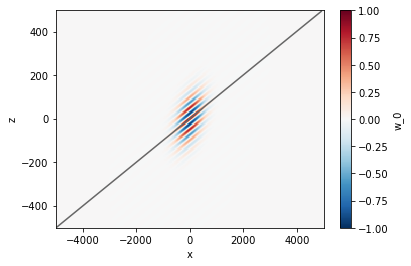

In [9]:
np.real(ds["w_0"]).plot(x="x")
xi.plot.contour(x="x", levels=[0], colors=["0.4"])

### distribution in spectral space

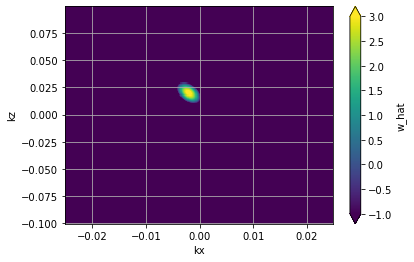

In [10]:
da = np.abs(ds["w_hat"])
da = np.log10(da)
da.plot(x="kx", vmin=-1, vmax=3)
plt.grid()
#xi.plot.contour(x="x", levels=[0], colors=["0.4"])

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


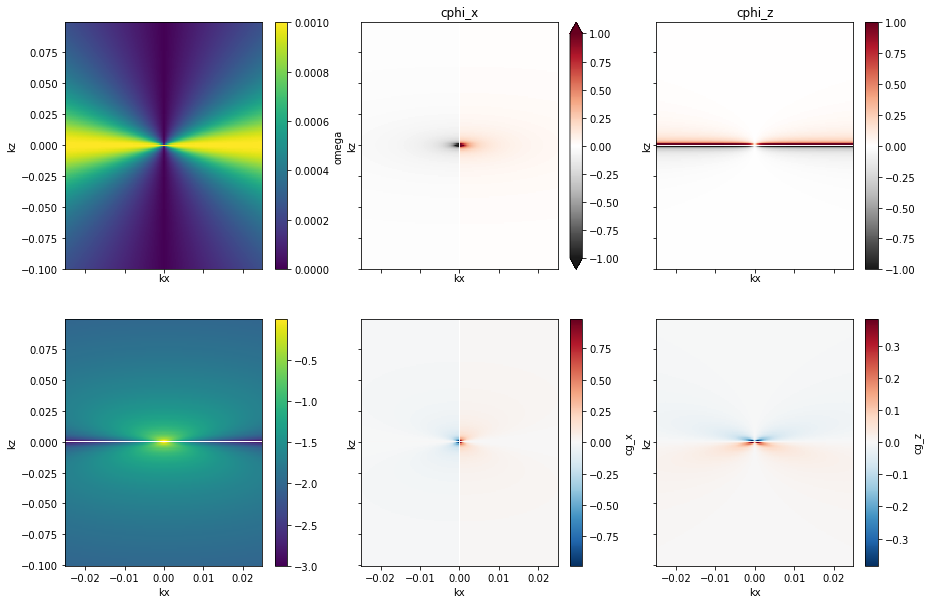

In [11]:
fig, axes = plt.subplots(2,3, sharex=True, sharey=True, figsize=(15,10))

ax = axes[0,0]
da = ds.omega # debug
#da = (ds.omega/f)
#da = da.where(da>1)
#da = np.log10(da)
da.plot(ax=ax, x="kx")
#cs = da.plot.contour(ax=ax, x="kx", levels=[1.01, 1.1, 2], colors=["0.5"])
#ax.clabel(cs, inline=1, fontsize=10)
#ax.set_title(f"omega/f, N/f={N/f:.1f}")

ax = axes[0,1]
da = (ds.omega/ds.kx)
da.plot(ax=ax, x="kx", vmin=-1, vmax=1, cmap="RdGy_r")
ax.set_title(f"cphi_x")

ax = axes[0,2]
da = (ds.omega/ds.kz)
da.plot(ax=ax, x="kx", vmin=-1, vmax=1, cmap="RdGy_r")
ax.set_title(f"cphi_z")

ax = axes[1,0]
np.log10(np.abs(ds.iw.cg)).plot(ax=ax, x="kx", vmin=-3)

ax = axes[1,1]
ds.iw.cg_x.plot(ax=ax, x="kx")

ax = axes[1,2]
ds.iw.cg_z.plot(ax=ax, x="kx")

### predict evolution at later time

In [12]:
#ds["time"] = ("time", np.arange(0, 80, 8/24)) # days
#ds["time"] = ("time", np.arange(0, 80, 20)) # days
ds["time"] = ("time", np.arange(0, 10, 1)) # days # debug
ds["w"] = (("x", "z", "time"), np.real(ifftn(ifftshift(ds.w_hat * np.exp(-1j* ds.omega * ds.time * 86400), axes=(0,1)), axes=(0,1))))

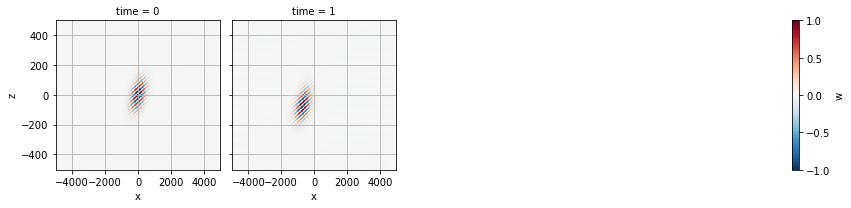

In [13]:
#_da = ds.w.sel(time=slice(0,1))
_da = ds.w.isel(time=slice(0,2))
axes = _da.plot(x="x", col="time", col_wrap=4)
for ax in axes.axes.flatten():
    ax.grid()

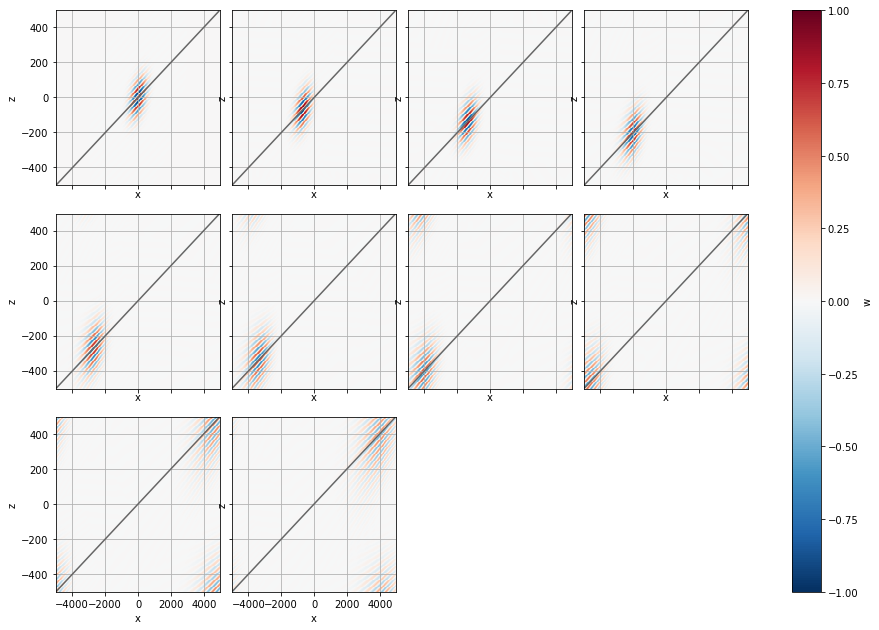

In [14]:
_da = ds.w #.isel(time=slice(0,None,12))
axes = _da.plot(x="x", col="time", col_wrap=4)
for ax in axes.axes.flatten():
    ax.grid()
    xi.plot.contour(ax=ax, x="x", levels=[0], colors=["0.4"])

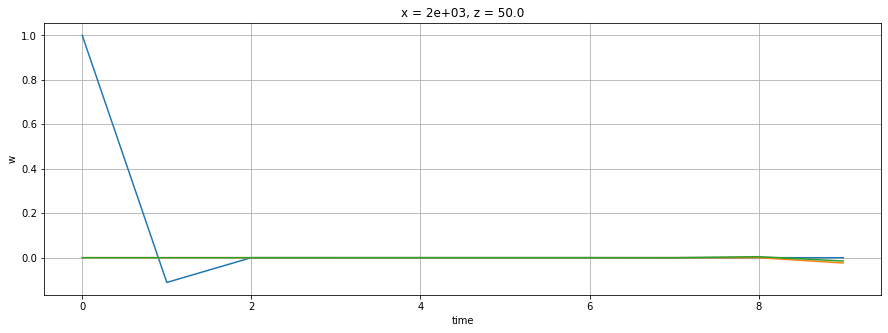

In [15]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
ds.w.sel(z=0, x=0, method="nearest").plot()
ds.w.sel(z=0, x=2e3, method="nearest").plot()
ds.w.sel(z=50, x=2e3, method="nearest").plot()
ax.grid()

---

## with a slopping boundary

In [22]:
ds0 = ds

In [23]:
ds = ds0.copy()

In [24]:
gamma = -.2 # bathymetric slope
z_bottom = -1000
z_bottom = 0

In [29]:
ds["kx_r"], ds["ky_r"], ds["kz_r"], ds["Q"], ds["q"] = \
        ds.iw.reflected_wave(gamma, 0, z_0=z_bottom,)
# tapper=1e3, interp_na_dim=["kz"]
# interp_na_dim=["kx", "kz"]

In [30]:
# tapper wavenumbers and response
kx_max = float(max(ds.kx))
kz_max = float(max(ds.kz))

tapper = lambda x, xmax: xmax*np.tanh(x/xmax)

ds["kx_r_tap"] = tapper(ds.kx_r, kx_max)
ds["kz_r_tap"] = tapper(ds.kz_r, kz_max)

Q_max = 1e2
ds["Q_tap"] = tapper(ds.Q, Q_max)

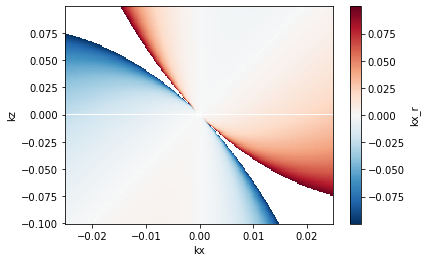

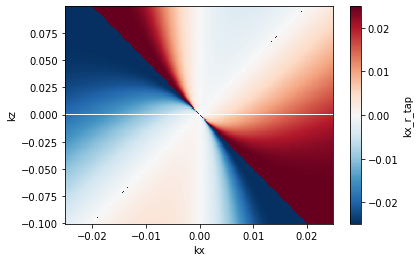

In [38]:
fig, ax = plt.subplots(1,1)
da = ds.kx_r
da = da.where(np.log10(np.abs(da))<-1)
da.plot(x="kx")

fig, ax = plt.subplots(1,1)
da = ds.kx_r_tap
#da = da.where(np.log10(np.abs(da))<2)
da.plot(x="kx")

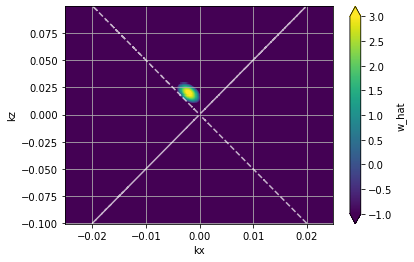

In [40]:
da = np.abs(ds["w_hat"])
da = np.log10(da)
da.plot(x="kx", vmin=-1, vmax=3)
plt.grid()
#xi.plot.contour(x="x", levels=[0], colors=["0.4"])

nslope = (ds.iw.cg_z/ds.iw.cg_x) / gamma
nslope.plot.contour(x="kx", levels=[-1, 1.], colors=["w"], alpha=0.7)

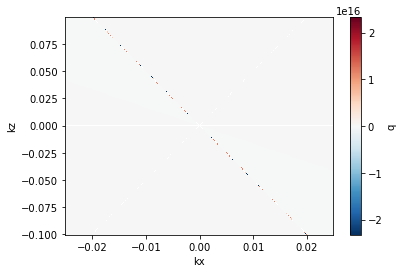

In [41]:
da = ds.q
#da = da.where(np.log10(np.abs(da))<2)
da.plot(x="kx")

In [23]:
# fill Nans
#ds["Q"] = ds["Q"].where( )
#ds["Q"] = ds["Q"].fillna(1e-6)

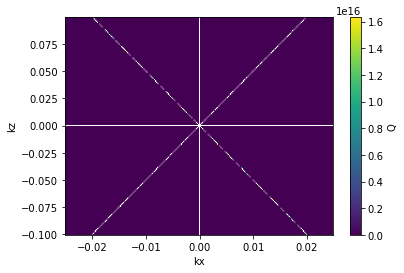

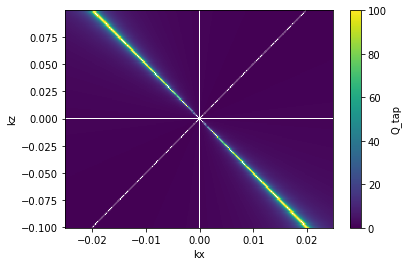

In [66]:
fig, ax = plt.subplots(1,1)
da = np.abs(ds.Q)
#da = np.log10(da)
da.plot(x="kx", ax=ax)

nslope = (ds.iw.cg_z/ds.iw.cg_x) / gamma
nslope.plot.contour(x="kx", levels=[-1, 1.], colors=["w"], alpha=0.3)

fig, ax = plt.subplots(1,1)
da = np.abs(ds.Q_tap)
#da = interp_na(da, ["kx","kz"])
#da = np.log10(da)
da.plot(x="kx", ax=ax)

nslope = (ds.iw.cg_z/ds.iw.cg_x) / gamma
nslope.plot.contour(x="kx", levels=[-1, 1.], colors=["w"], alpha=0.3)

In [67]:
# filter out extreme values
#logQ = np.log10(np.abs(ds["Q"]))
#ds["Q"] = ds["Q"].where( logQ<2 , other=1e2)
#ds["Q"] = ds["Q"].where( logQ>-2 , other=1e-2)

ds["w_hat_r"] = ds["w_hat"] * ds["Q"]

ds["w_hat_r_tap"] = ds["w_hat"] * interp_na(ds["Q_tap"], ["kx","kz"])

Look at the distribution of reflected wavenumbers.
These wavenumbers do not match the original grid naturally.

(-0.1, 0.099)

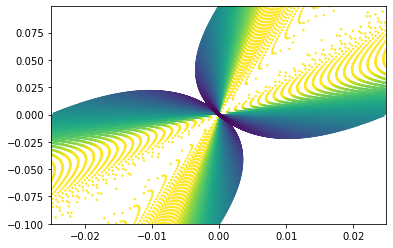

In [68]:
fig, ax = plt.subplots(1,1)
#da.plot(x="kx", ax=ax)
ax.scatter(ds.kx_r, ds.kz_r, c=np.abs(ds.Q), s=2, vmax=2)
ax.set_xlim(ds.kx.values[[0,-1]], )
ax.set_ylim(ds.kz.values[[0,-1]], )

(-0.1, 0.099)

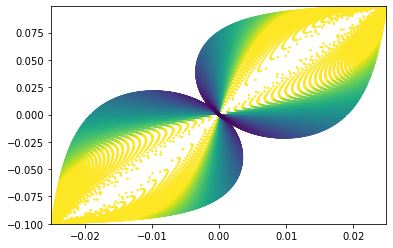

In [69]:
fig, ax = plt.subplots(1,1)
#da.plot(x="kx", ax=ax)
ax.scatter(ds.kx_r_tap, ds.kz_r_tap, c=np.abs(ds.Q_tap), s=2, vmax=2)
ax.set_xlim(ds.kx.values[[0,-1]], )
ax.set_ylim(ds.kz.values[[0,-1]], )

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/xarray/core/computation.py:727: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


(-0.1, 0.099)

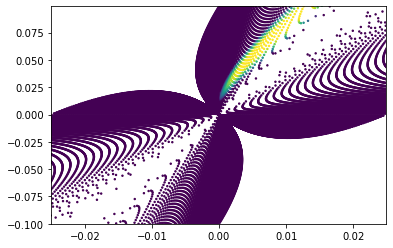

In [70]:
fig, ax = plt.subplots(1,1)
ax.scatter(ds.kx_r, ds.kz_r, c=np.log10(np.abs(ds.w_hat_r)), s=2, vmin=-1, vmax=3)
ax.set_xlim(ds.kx.values[[0,-1]], )
ax.set_ylim(ds.kz.values[[0,-1]], )

(-0.1, 0.099)

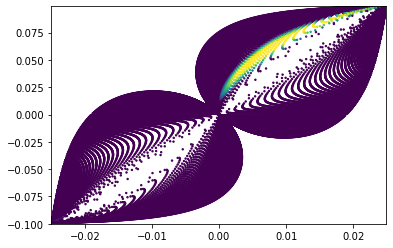

In [71]:
fig, ax = plt.subplots(1,1)
ax.scatter(ds.kx_r_tap, ds.kz_r_tap, c=np.log10(np.abs(ds.w_hat_r_tap)), s=2, vmin=-1, vmax=3)
ax.set_xlim(ds.kx.values[[0,-1]], )
ax.set_ylim(ds.kz.values[[0,-1]], )

In [27]:
_ds = ds[["kx_r", "kz_r", "Q", "w_hat_r"]].stack(pt=["kx", "kz"])
# drop NaNs
_ds = _ds.where( ~np.isnan(_ds.kx_r) & ~np.isnan(_ds.kz_r) & ~np.isnan(_ds.Q), drop=True)
# get rid of points with very large wavenumbers
_ds = _ds.where( (_ds.kx_r>2*ds.kx.values[0]) & (_ds.kx_r<2*ds.kx.values[-1]) 
                & (_ds.kz_r>2*ds.kz.values[0]) & (_ds.kz_r<2*ds.kz.values[-1]), drop=True) 

kx = (ds.kx + 0*ds.kz).values
kz = (ds.kx*0 + ds.kz).values

scale_x = 1/ds.kx.values[-1]
scale_z = 1/ds.kz.values[-1]

ds["w_hat_r_interp"] = (("kx","kz"), griddata((_ds.kx_r*scale_x, _ds.kz_r*scale_z), _ds.w_hat_r, (kx*scale_x, kz*scale_z), method='nearest', fill_value=0))

(0.0, 1.001001001001001)

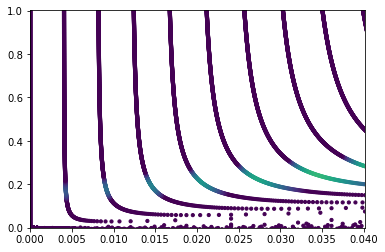

In [28]:
fig, ax = plt.subplots(1,1)

_sx, _sz = scale_x, scale_z

ax.scatter(_ds.kx_r*_sx, _ds.kz_r*_sz, c=np.log10(np.abs(_ds.w_hat_r)), s=10, vmin=-1, vmax=3)

#nslope = (ds.iw.cg_z/ds.iw.cg_x) / gamma
#nslope.plot.contour(x="kx", levels=[-1, 1.], colors=["k"], alpha=0.7)

ax.set_xlim(0,1e-3*_sx)
ax.set_ylim(0,1e-1*_sz)

(0.0, 0.1)

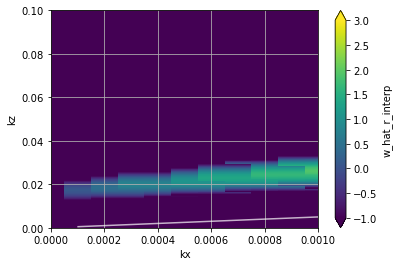

In [29]:
fig, ax = plt.subplots(1,1)

da = np.abs(ds["w_hat_r_interp"])
da = np.log10(da)
da.plot(x="kx", vmin=-1, vmax=3)
plt.grid()
#xi.plot.contour(x="x", levels=[0], colors=["0.4"])

# check
#ax.scatter(_ds.kx_r, _ds.kz_r, c=np.log10(np.abs(_ds.w_hat_r)), s=10, vmin=-1, vmax=3)

nslope = (ds.iw.cg_z/ds.iw.cg_x) / gamma
nslope.plot.contour(x="kx", levels=[-1, 1.], colors=["w"], alpha=0.7)

ax.set_xlim(0,1e-3)
ax.set_ylim(0,1e-1)

In [30]:
ds["w_r"] = (("x", "z", "time"), np.real(ifftn(ifftshift(ds.w_hat_r_interp * np.exp(-1j* ds.omega * ds.time * 86400), axes=(0,1)), axes=(0,1))))

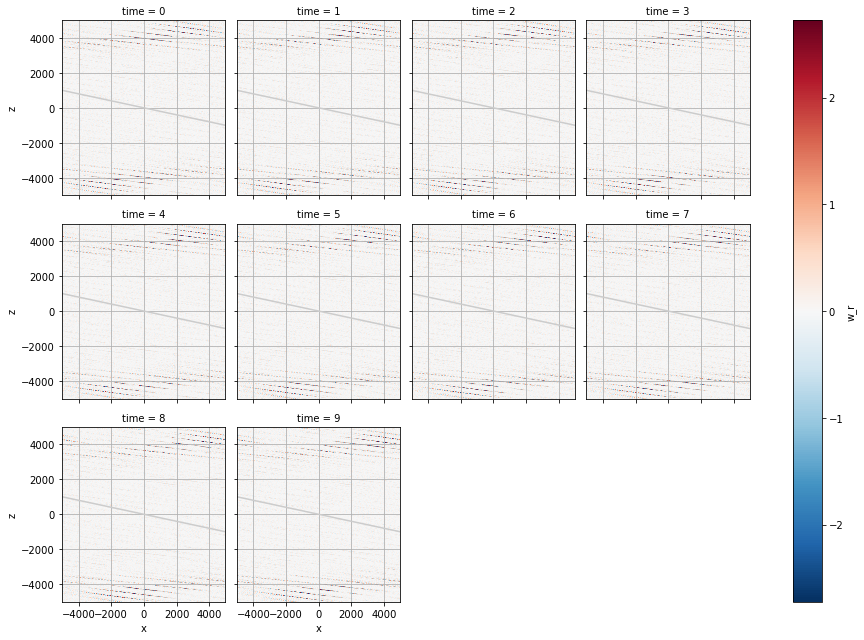

In [31]:
_da = ds.w_r #.isel(time=slice(0,None,12*2))
axes = _da.plot(x="x", col="time", col_wrap=4)
for ax in axes.axes.flatten():
    ax.grid()
    ax.plot(ds.x, z_bottom + gamma*ds.x, color="0.8")
    #xi.plot.contour(ax=ax, x="x", levels=[0], colors=["0.4"])

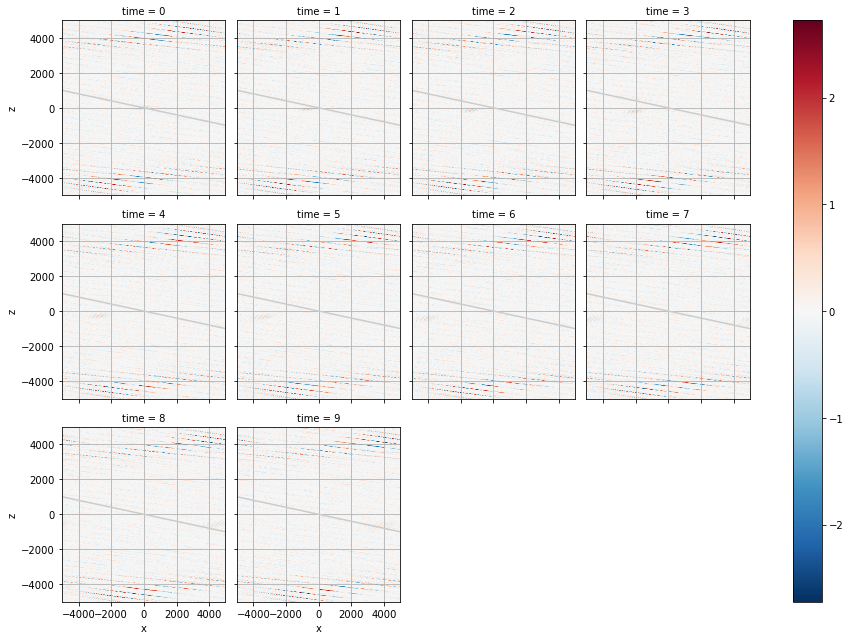

In [32]:
_da = (ds.w + ds.w_r) #.isel(time=slice(0,None,12*2))
axes = _da.plot(x="x", col="time", col_wrap=4)
for ax in axes.axes.flatten():
    ax.grid()
    ax.plot(ds.x, z_bottom + gamma*ds.x, color="0.8")
    #xi.plot.contour(ax=ax, x="x", levels=[0], colors=["0.4"])

Try NUFFT on a snapshot first (t=0)

- tapper spectrally
- get rid of frequencies larger than the box (try without) 

In [72]:
from pynufft import NUFFT

In [93]:
# start setting up NUFFT

_ds = ds[["kx_r_tap", "kz_r_tap", "Q_tap", "w_hat_r_tap"]].stack(pt=["kx", "kz"])
# drop NaNs
_ds = _ds.where( ~np.isnan(_ds.kx_r_tap) & ~np.isnan(_ds.kz_r_tap) & ~np.isnan(_ds.Q_tap), drop=True)
# get rid of points with very large wavenumbers
#_ds = _ds.where( (_ds.kx_r>2*ds.kx.values[0]) & (_ds.kx_r<2*ds.kx.values[-1]) 
#                & (_ds.kz_r>2*ds.kz.values[0]) & (_ds.kz_r<2*ds.kz.values[-1]), drop=True) 

# om
om = np.hstack((_ds.kx_r_tap.values.flatten()[:,None]*dx*2*np.pi,
                _ds.kz_r_tap.values.flatten()[:,None]*dz*2*np.pi,
               ))

#
Nd = (ds.x.size, ds.z.size) # image size
print('setting image dimension Nd...', Nd)
# ds.omega
Kd = (Nd[0]*2, Nd[1]*2)  # k-space size
print('setting spectrum dimension Kd...', Kd)
Jd = (6, 6)  # interpolation size
print('setting interpolation size Jd...', Jd)

setting image dimension Nd... (500, 200)
setting spectrum dimension Kd... (1000, 400)
setting interpolation size Jd... (6, 6)


In [94]:
NufftObj = NUFFT()
NufftObj.plan(om, Nd, Kd, Jd)

0

In [95]:
y = _ds.w_hat_r_tap.values
image0 = NufftObj.solve(y, solver='cg',maxiter=50)
image2 = NufftObj.adjoint(y ) # adjoint
image3 = NufftObj.solve(y, solver='L1TVOLS',maxiter=50,rho=0.1)

/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/pynufft/nufft/_nufft_class_methods_cpu.py:229: RuntimeWarning: overflow encountered in multiply
  xx = x * self.sn
/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/pynufft/nufft/_nufft_class_methods_cpu.py:229: RuntimeWarning: invalid value encountered in multiply
  xx = x * self.sn
/Users/aponte/.miniconda3/envs/dashydro/lib/python3.8/site-packages/pynufft/linalg/solve_cpu.py:102: RuntimeWarning: invalid value encountered in multiply
  rhs = mu*AHyk# + df - bf)   # right hand side


In [96]:
any(np.isnan(om).flatten())

False

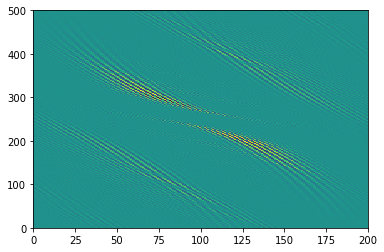

In [107]:
plt.pcolormesh(image0.real)

http://jyhmiinlin.github.io/pynufft/tutor/more2D.html

In [42]:
import numpy
import scipy.misc
import matplotlib.pyplot

from pynufft import NUFFT

In [43]:
import pkg_resources
DATA_PATH = pkg_resources.resource_filename('pynufft', './src/data/')
om = numpy.load(DATA_PATH+'om2D.npz')['arr_0']
om.shape

(122880, 2)

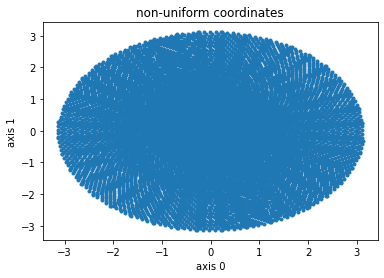

In [53]:
matplotlib.pyplot.plot(om[::10,0],om[::10,1],'.')
matplotlib.pyplot.title('non-uniform coordinates')
matplotlib.pyplot.xlabel('axis 0')
matplotlib.pyplot.ylabel('axis 1')
matplotlib.pyplot.show()

In [32]:
NufftObj = NUFFT()

In [33]:
Nd = (256, 256)  # image size
print('setting image dimension Nd...', Nd)
Kd = (512, 512)  # k-space size
print('setting spectrum dimension Kd...', Kd)
Jd = (6, 6)  # interpolation size
print('setting interpolation size Jd...', Jd)

setting image dimension Nd... (256, 256)
setting spectrum dimension Kd... (512, 512)
setting interpolation size Jd... (6, 6)


In [46]:
NufftObj.plan(om, Nd, Kd, Jd)

0

loading image...


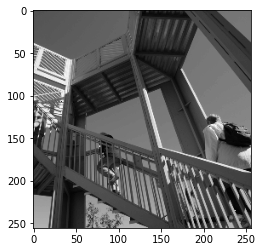

In [47]:
image = scipy.misc.ascent()[::2, ::2]
image=image/numpy.max(image[...])

print('loading image...')

matplotlib.pyplot.imshow(image.real, cmap=matplotlib.cm.gray)
matplotlib.pyplot.show()

In [48]:
y = NufftObj.forward(image)

In [51]:
y.shape

(122880,)

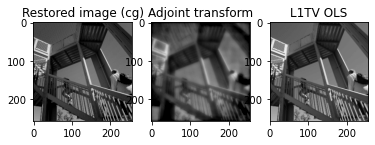

In [49]:
image0 = NufftObj.solve(y, solver='cg',maxiter=50)
image3 = NufftObj.solve(y, solver='L1TVOLS',maxiter=50,rho=0.1)

image2 = NufftObj.adjoint(y ) # adjoint


matplotlib.pyplot.subplot(1,3,1)
matplotlib.pyplot.title('Restored image (cg)')
matplotlib.pyplot.imshow(image0.real, cmap=matplotlib.cm.gray, norm=matplotlib.colors.Normalize(vmin=0.0, vmax=1))


matplotlib.pyplot.subplot(1,3,2)
matplotlib.pyplot.imshow(image2.real, cmap=matplotlib.cm.gray, norm=matplotlib.colors.Normalize(vmin=0.0, vmax=5))
matplotlib.pyplot.title('Adjoint transform')


matplotlib.pyplot.subplot(1,3,3)
matplotlib.pyplot.title('L1TV OLS')
matplotlib.pyplot.imshow(image3.real, cmap=matplotlib.cm.gray, norm=matplotlib.colors.Normalize(vmin=0.0, vmax=1))

matplotlib.pyplot.show()